# Week 7 Data acqusition from OpenBCI

In [174]:
# import require library for preprocess
import mne
import numpy as np
from mne.channels import make_standard_montage
import matplotlib.pyplot as plt
from mne.datasets import eegbci
import scipy
import pickle
import seaborn as sns
from scipy.signal import filtfilt
import pyxdf

# import require library for classification
from sklearn.svm import SVC # SVM library
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis # LDA library
from sklearn.neighbors import KNeighborsClassifier # KNN library

from sklearn.metrics import classification_report,confusion_matrix # Result representation

# OPENBCI

## 1 Read recorded data from OpenBCI (xdf file)

In [175]:
import pyxdf
import mne
import numpy as np
streams, header = pyxdf.load_xdf("data/sub-thai_ses-S003_task-Default_run-001_eeg.xdf") #Example Data from Lab Recoder

if streams[0]['info']['type'][0] == 'Markers': #Check
    raw_stream = streams[1]
    event_data = streams[0]
else:
    raw_stream = streams[0]
    event_data = streams[1]

raw_data = raw_stream["time_series"].T #From Steam variable this query is EEG data
channels = ['CH1','CH2','CH3','CH4','CH5','CH6','CH7','CH8'] #Set your target EEG channel name
info = mne.create_info(
    ch_names= channels,
    ch_types= ['eeg']*len(channels),
    sfreq= 250 #OpenBCI Frequency acquistion
)
raw_OpenBCI = mne.io.RawArray(raw_data, info, verbose=False)    


In [176]:
raw_OpenBCI

Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,0.00 Hz
Lowpass,125.00 Hz


In [177]:
raw_OpenBCI.ch_names

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']

## 2. Filter

Effective window size : 8.192 (s)


C:\Users\bcc35\AppData\Local\Temp\ipykernel_40284\4197467807.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\Users\bcc35\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


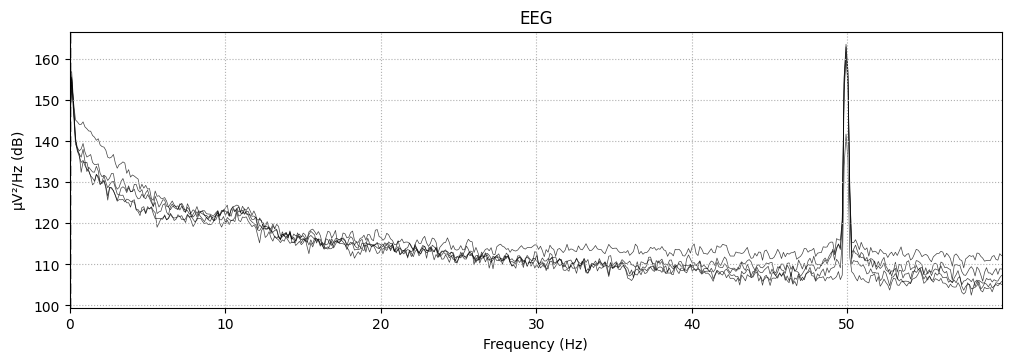

In [178]:
raw_OpenBCI.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 825 samples (3.300 s)

Filtering raw data in 1 contiguous segment
Setting up band-stop filter from 49 - 51 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandstop filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 49.38
- Lower transition bandwidth: 0.50 Hz (-6 dB cutoff frequency: 49.12 Hz)
- Upper passband edge

[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
[Parallel(n_jobs=1)]: Done   8 out of   8 | elapsed:    0.0s finished
C:\Users\bcc35\AppData\Local\Temp\ipykernel_40284\2478548851.py:3: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
c:\Users\bcc35\AppData\Local\Programs\Python\Python311\Lib\site-packages\mne\viz\utils.py:165: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  (fig or plt).show(**kwargs)


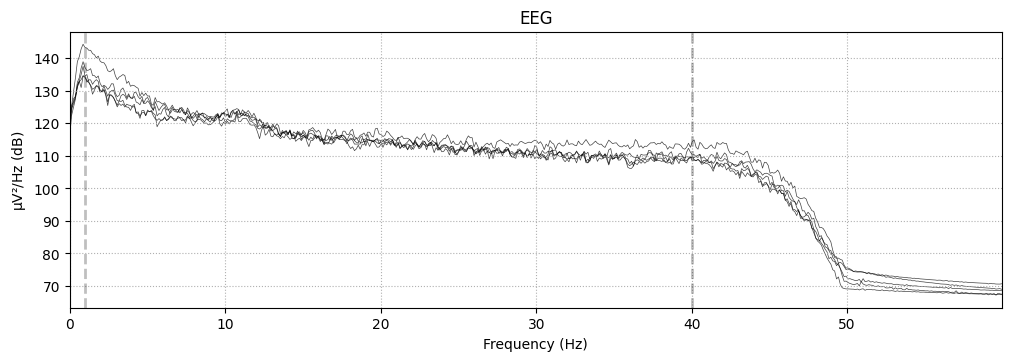

In [179]:
OpenBCI_filter = raw_OpenBCI.copy().filter(l_freq=1, h_freq=40) #band-pass function
OpenBCI_filter = OpenBCI_filter.copy().notch_filter(freqs=50) #notch filter function
OpenBCI_filter.compute_psd(fmax=60).plot(picks=raw_OpenBCI.ch_names[0:5])
plt.show()

## 3.Epoching

In [180]:
sfreq= 250
# event_index = np.array(event_data["time_series"]) #Get all event marker of experiment 
event_timestamp = (np.array(event_data["time_stamps"]).T * sfreq) - (raw_stream['time_stamps'][0] * sfreq) #Timestamp when event marked


In [181]:
# event_data["time_series"]

In [182]:
event_index = []

for i in range (len(event_data["time_series"])):
    # print(event_data["time_series"][i][0])
    event_index.append(event_data["time_series"][i][0])
    # np.append(event_index,event_data["time_series"][i][0])
np_event_index = np.array(event_index)
print(np_event_index)

['101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101' '201'
 '201' '101' '101' '101' '101' '101' '101' '201' '201' '201' '101' '201'
 '101' '101' '101' '101' '201' '101' '101' '101' '101' '101' '101' '101'
 '201' '101' '101' '101' '101' '101' '101' '101' '101' '101' '201' '101'
 '101' '101' '']


In [183]:
# events_id2 = {'U': 1, 'R': 2, 'L': 3, 'D': 4, '': 5}
events_id2 = {'101': 1,'201' : 2,'': 5}
# # Use vectorized mapping with np.vectorize
event_index = np.vectorize(events_id2.get)(event_index)

In [184]:
# event_data["time_series"]

In [185]:
events2 = np.column_stack((np.array(event_timestamp, dtype = int),np.zeros(len(event_timestamp), dtype = int),np.array(event_index, dtype = int)))


In [186]:
# count mark
# count_101 = 0
# els = 0
# for i in range(len(event_data["time_series"])):
#     if event_data["time_series"][i][0] == '101' :
#         count_101 += 1
#     elif event_data["time_series"][i][0] == '201' :
#         els += 1

# print(count_101,els)

In [187]:
events2

array([[ 3839,     0,     1],
       [ 4829,     0,     1],
       [ 5755,     0,     1],
       [ 6707,     0,     2],
       [ 7619,     0,     1],
       [ 8577,     0,     1],
       [ 9548,     0,     1],
       [10505,     0,     1],
       [11492,     0,     1],
       [12445,     0,     1],
       [13350,     0,     1],
       [14318,     0,     2],
       [15257,     0,     2],
       [16241,     0,     1],
       [17151,     0,     1],
       [18144,     0,     1],
       [19115,     0,     1],
       [20031,     0,     1],
       [20980,     0,     1],
       [21892,     0,     2],
       [22800,     0,     2],
       [23796,     0,     2],
       [24708,     0,     1],
       [25621,     0,     2],
       [26523,     0,     1],
       [27454,     0,     1],
       [28391,     0,     1],
       [29368,     0,     1],
       [30348,     0,     2],
       [31253,     0,     1],
       [32156,     0,     1],
       [33067,     0,     1],
       [34021,     0,     1],
       [34

In [188]:
OpenBCI_epochs = mne.Epochs(OpenBCI_filter, events2, 
        tmin= -0.5,     # init timestamp of epoch (0 means trigger timestamp same as event start)
        tmax= 2,    # final timestamp (10 means set epoch duration 10 second)
        event_id =events_id2,
        preload = True,
        event_repeated='drop',
        baseline=(-0.5, 0)
    )

Not setting metadata
51 matching events found
Applying baseline correction (mode: mean)
0 projection items activated
Using data from preloaded Raw for 51 events and 626 original time points ...
0 bad epochs dropped


In [189]:
OpenBCI_epochs

Number of events,51
Events,: 1101: 40201: 10
Time range,-0.500 – 2.000 s
Baseline,-0.500 – 0.000 s


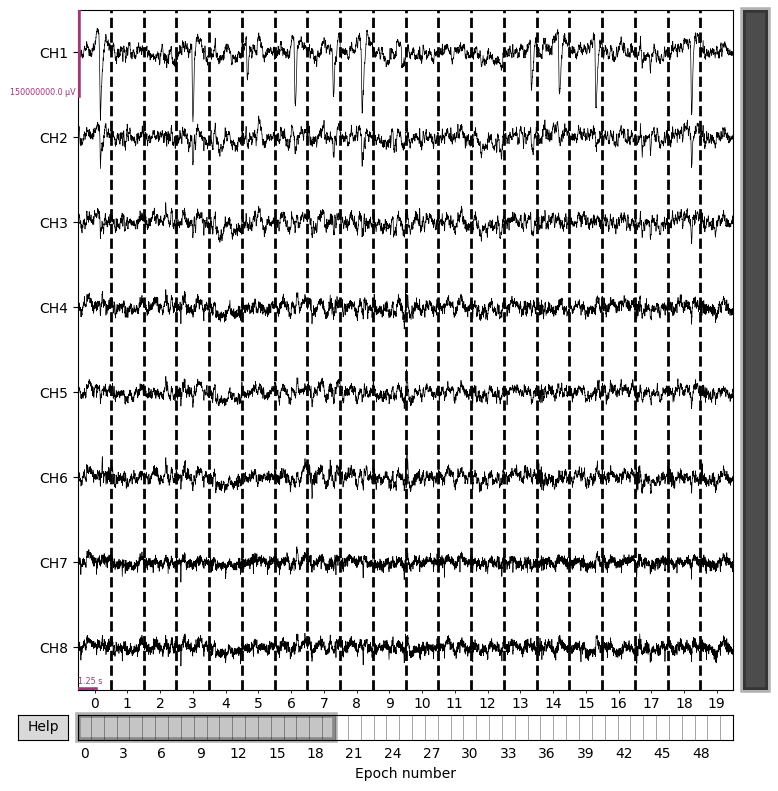

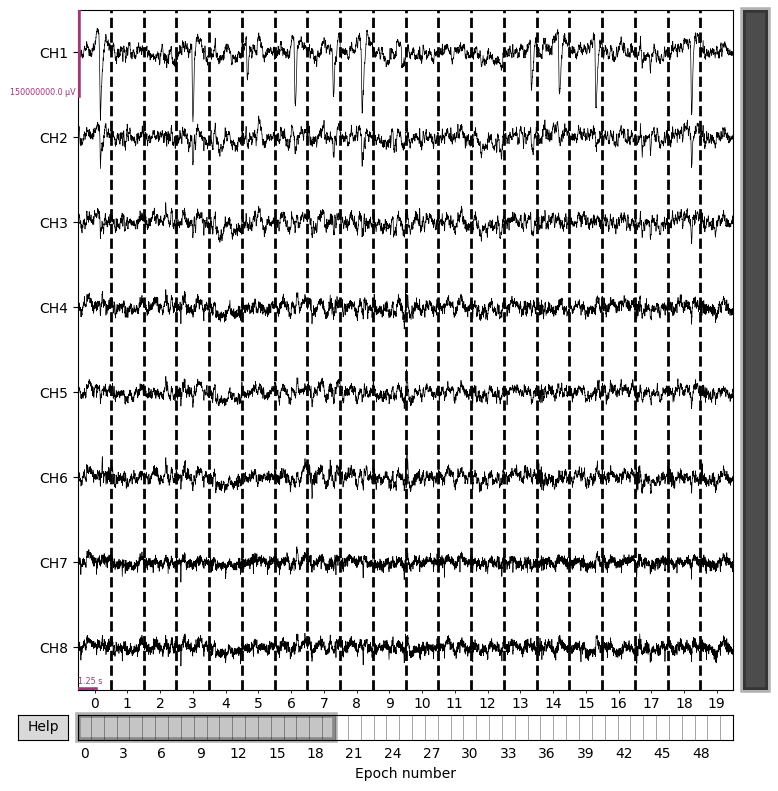

In [190]:
OpenBCI_epochs.plot(scalings = 75)

In [191]:
evoked_target = OpenBCI_epochs['201'].average()
evoked_nontarget = OpenBCI_epochs['101'].average()


C:\Users\bcc35\AppData\Local\Temp\ipykernel_40284\106032847.py:1: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked_target.plot(spatial_colors=True, titles='Target (P300)')


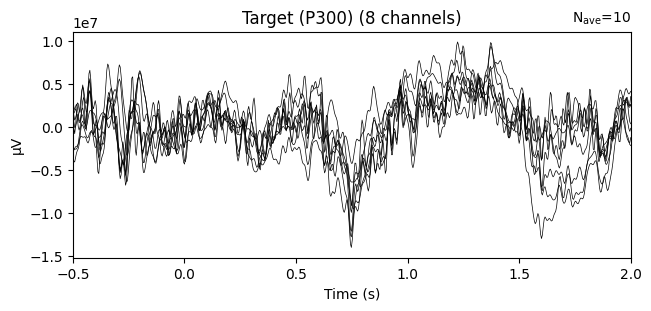

C:\Users\bcc35\AppData\Local\Temp\ipykernel_40284\106032847.py:2: RuntimeWarning: Channel locations not available. Disabling spatial colors.
  evoked_nontarget.plot(spatial_colors=True, titles='Non-Target')


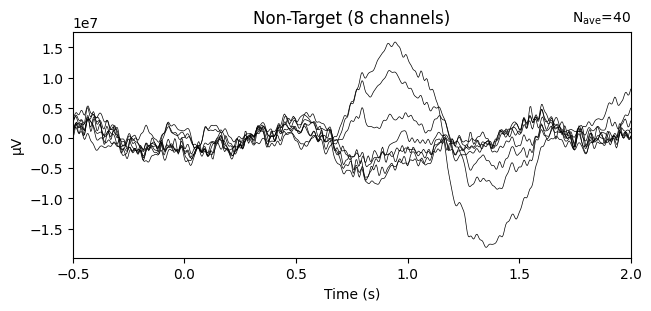

In [192]:
evoked_target.plot(spatial_colors=True, titles='Target (P300)')
evoked_nontarget.plot(spatial_colors=True, titles='Non-Target')
plt.show()


In [193]:
(evoked_target.ch_names)

['CH1', 'CH2', 'CH3', 'CH4', 'CH5', 'CH6', 'CH7', 'CH8']

combining channels using "mean"
combining channels using "mean"


C:\Users\bcc35\AppData\Local\Temp\ipykernel_40284\4230518266.py:1: RuntimeWarning: Only 1 channel in "picks"; cannot combine by method "mean".
  mne.viz.plot_compare_evokeds(
C:\Users\bcc35\AppData\Local\Temp\ipykernel_40284\4230518266.py:1: RuntimeWarning: Cannot find channel coordinates in the supplied Evokeds. Not showing channel locations.
  mne.viz.plot_compare_evokeds(


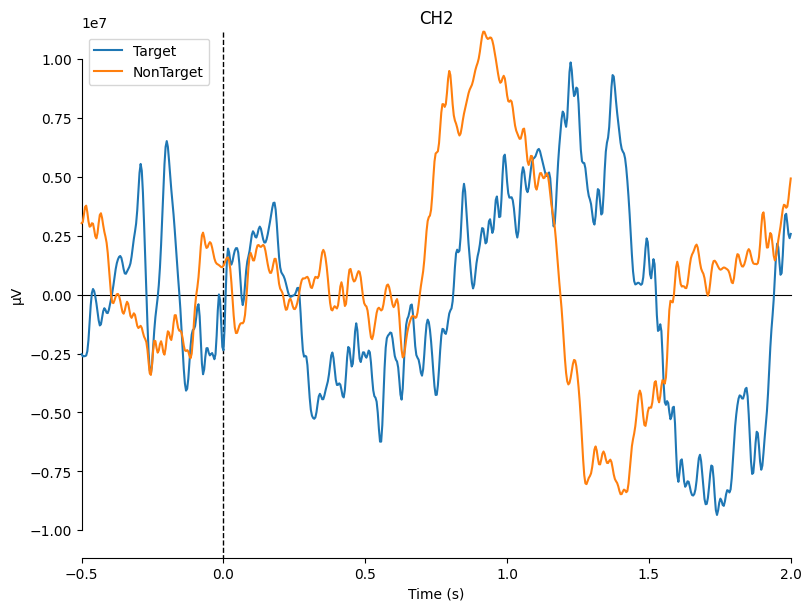

In [194]:
mne.viz.plot_compare_evokeds(
    dict(Target=evoked_target, NonTarget=evoked_nontarget),
    picks='CH2',  # or any channel where P300 is expected
    combine='mean'
)
plt.show()


In [200]:
channel_mapping = {
    'CH1': 'Fz',
    'CH2': 'Cz',
    'CH3': 'Pz',
    'CH4': 'Oz',
    'CH5': 'P3',
    'CH6': 'P4',
    'CH7': 'O1',
    'CH8': 'O2'
}
OpenBCI_filter.rename_channels(channel_mapping)


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,Not available
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [203]:
montage = mne.channels.make_standard_montage('standard_1020')
OpenBCI_filter.set_montage(montage)  # Apply to your preprocessed Raw object


Measurement date,Unknown
Experimenter,Unknown
Participant,Unknown
Digitized points,11 points
Good channels,8 EEG
Bad channels,None
EOG channels,Not available
ECG channels,Not available
Sampling frequency,250.00 Hz
Highpass,1.00 Hz
Lowpass,40.00 Hz


In [ ]:
evoked_target = OpenBCI_epochs['201'].average()
evoked_target.plot_topomap(times=[0.3], ch_type='eeg')


AttributeError: 'RawArray' object has no attribute 'plot_topomap'